In [1]:
from google.colab import drive

drive.mount("/content/gdrive")  

Mounted at /content/gdrive


In [15]:
pip install tensorflow numpy matplotlib pandas scipy

In [16]:
# Import needed packages
import numpy as np # Arrays
import pandas as pd # Importing and organizing data
import matplotlib.pyplot as plt # Plotting
from scipy.integrate import simps # Simpson integration
from tensorflow import keras

In [17]:
# Get train and validation data
train_data_csv = np.array(pd.read_csv("/content/gdrive/My Drive/dados_dia/Pima-Diabetes.csv"))
print(train_data_csv.shape)

# Separate validation data and label
validation_data = train_data_csv[np.int(train_data_csv.shape[0]*.8):,:-1]
print(validation_data.shape)
validation_label = train_data_csv[np.int(train_data_csv.shape[0]*.8):,-1]
print(validation_label.shape)

# Separate train data and label
train_data = train_data_csv[:np.int(train_data_csv.shape[0]*.8),:-1]
print(train_data.shape)
train_label = train_data_csv[:np.int(train_data_csv.shape[0]*.8),-1]
print(train_label.shape)

# Get test data
test_data = np.array(pd.read_csv("/content/gdrive/My Drive/dados_dia/Test-Group-2.csv"))
print(test_data.shape)

(757, 9)
(152, 8)
(152,)
(605, 8)
(605,)
(9, 8)


In [18]:
from tensorflow.keras.models import Sequential # Model of sequential layers
from tensorflow.keras.layers import Dense, Dropout # Layers to be used

# Model definition
model = Sequential([
                    Dense(1024, activation="sigmoid", input_shape=(8,)),
                    Dropout(0.3),
                    Dense(512, activation="sigmoid"),
                    Dropout(0.2),
                    Dense(256, activation="sigmoid"),
                    Dropout(0.1),
                    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              9216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [19]:
# Model compilation
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

In [20]:
# Model fitting
history = model.fit(
    train_data,
    train_label,
    epochs = 100,
    batch_size = 605,
)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.6545
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.8783 - accuracy: 0.3471
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6132
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6545
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7406 - accuracy: 0.6545
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7091 - accuracy: 0.6545
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6590 - accuracy: 0.6545
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6283 - accuracy: 0.6529
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6423 - accuracy: 0.6479
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.5950
Epoch 11/100
1/1 [===========

In [21]:
# Model testing
model.evaluate(
    validation_data,
    validation_label
)

5/5 [==============================] - 0s 3ms/step - loss: 0.5011 - accuracy: 0.7500


[0.5011223554611206, 0.75]

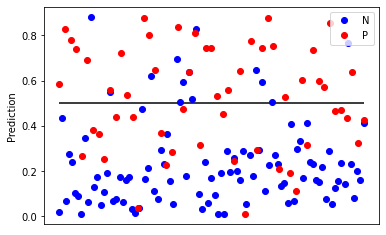

0.5 threshold accuracy: 0.750000


In [22]:
# Show predictions with 0.5 threshold, as expected of a sigmoid fit

pred = model.predict(validation_data).flatten() # Make prediction over validation data

N = pred[np.where(validation_label == 0)] # Negatives
P = pred[np.where(validation_label == 1)] # Positives

x1 = np.linspace(0, 1, len(N)) # X axis for negatives
x2 = np.linspace(0, 1, len(P)) # X axis for positives

# Plotting negatives in blue and positives in red
plt.plot(x1, N, "o", color="blue", label="N")
plt.plot(x2, P, "o", color="red", label="P")
plt.hlines(0.5, 0, 1)
plt.xticks([])
plt.ylabel("Prediction")
plt.legend(loc="best")
plt.show()
print("0.5 threshold accuracy: %.6f" % (len(np.where((np.sign(pred-0.5)+1)/2 == validation_label)[0])/len(pred)))

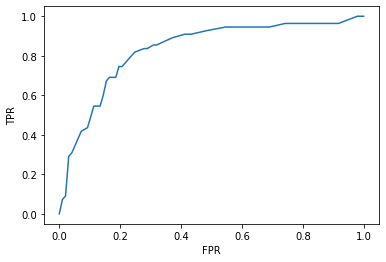

AUC: 0.831199364781839


In [23]:
# ROC curve
def ROC(th, pred, label):

    FPR = np.zeros(len(th)) # False positive rate
    TPR = np.zeros(len(th)) # True positive rate

    N = pred[np.where(label == 0)] # Negatives
    P = pred[np.where(label == 1)] # Positives

    for i in range(len(th)):
    
        FN = len(np.where(P <= th[i])[0]) # False negatives

        FP = len(np.where(N > th[i])[0]) # False positives

        TN = len(np.where(N <= th[i])[0]) # True negatives

        TP = len(np.where(P > th[i])[0]) # True positives

        FPR[i] = FP /(FP+TN)
        TPR[i] = TP /(TP+FN)

    result = np.concatenate((FPR, TPR)).reshape((2, len(th))).T

    return result[np.argsort(result[:,0])]

# Different thresholds
threshold = np.linspace(0, 1, 100)

# Save ROC curve
roc = ROC(threshold, pred, validation_label)

# Exclude repeated values to allow integration
r = roc[:1]
for i in range(1,len(roc)):

    if (roc[i,0] != roc[i-1,0]):

        r = np.append(r, roc[i])

# ROC curve without repeated values
roc = r.reshape((np.int(len(r)/2), 2))

# Plotting
plt.plot(*roc.T)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# AUC index
print("AUC:", simps(roc[:,1], roc[:,0]))

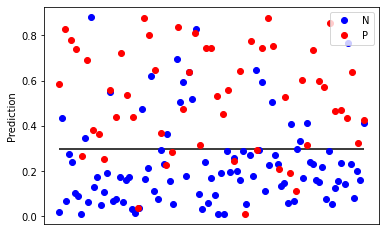

Best threshold: 0.297330
0.297330 threshold accuracy: 0.789474


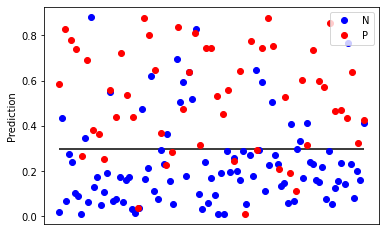

Best threshold (2nd method): 0.297330
0.297330 threshold accuracy: 0.789474


In [24]:
# Get best threshold, maximizing TP and TN
def fit_threshold(P, N, th_n=1000):

    th = np.linspace(0, 1, th_n)
    r = np.zeros(len(th))

    for i in range(len(th)):

        FN = len(np.where(P < th[i])[0]) # False negatives

        FP = len(np.where(N > th[i])[0]) # False positives

        TN = len(np.where(N < th[i])[0]) # True negatives

        TP = len(np.where(P > th[i])[0]) # True positives

        r[i] = TN+TP-FN-FP

    th_best = th[np.where(r == np.max(r))[0][0]]

    x1 = np.linspace(0, 1, len(N)) # X axis for negatives
    x2 = np.linspace(0, 1, len(P)) # X axis for positives

    # Plotting negatives in blue and positives in red
    plt.plot(x1, N, "o", color="blue", label="N")
    plt.plot(x2, P, "o", color="red", label="P")
    plt.hlines(th_best, 0, 1)
    plt.xticks([])
    plt.ylabel("Prediction")
    plt.legend(loc="upper right")
    plt.show()

    return th_best

def fit_threshold2(data, label, model, th_n=1000):

    th = np.linspace(0, 1, th_n)
    r = np.zeros(len(th))

    pred = model.predict(data).flatten()

    for i in range(len(th)):

        r[i] = len(np.where((np.sign(pred-th[i])+1)/2 == label)[0])

    th_best = th[np.where(r == np.max(r))[0][0]]

    N = pred[np.where(label == 0)] # Negatives
    P = pred[np.where(label == 1)] # Positives

    x1 = np.linspace(0, 1, len(N)) # X axis for negatives
    x2 = np.linspace(0, 1, len(P)) # X axis for positives

    # Plotting negatives in blue and positives in red
    plt.plot(x1, N, "o", color="blue", label="N")
    plt.plot(x2, P, "o", color="red", label="P")
    plt.hlines(th_best, 0, 1)
    plt.xticks([])
    plt.ylabel("Prediction")
    plt.legend(loc="upper right")
    plt.show()

    return th_best

N = pred[np.where(validation_label == 0)] # Negatives
P = pred[np.where(validation_label == 1)] # Positives

th_best = fit_threshold(P, N, 10000)

print("Best threshold: %.6f" % th_best)
print("%.6f threshold accuracy: %.6f" % (th_best, len(np.where((np.sign(pred-th_best)+1)/2 == validation_label)[0])/len(pred)))

th_best2 = fit_threshold2(validation_data, validation_label, model, 10000)

print("Best threshold (2nd method): %.6f" % th_best2)
print("%.6f threshold accuracy: %.6f" % (th_best2, len(np.where((np.sign(pred-th_best2)+1)/2 == validation_label)[0])/len(pred)))

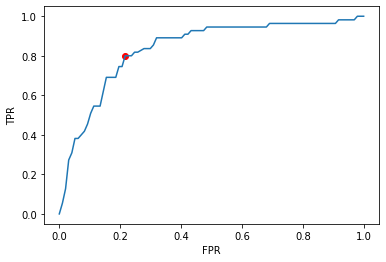

In [25]:
# Plot ROC marking best threshold point

# Different thresholds
threshold = np.linspace(0, 1, 1000)

# Save ROC curve
roc = ROC(threshold, pred, validation_label)

# Exclude repeated values to allow integration
r = roc[:1]
for i in range(1,len(roc)):

  if (roc[i,0] != roc[i-1,0]):
    
    r = np.append(r, roc[i])

# ROC curve without repeated values
roc = r.reshape((np.int(len(r)/2), 2))

# Plotting
plt.plot(*roc.T)
plt.xlabel("FPR")
plt.ylabel("TPR")

# Mark best threshold in red on the plot
r_best = ROC([th_best], pred, validation_label)
plt.scatter(*r_best[0], color="red")
plt.show()

In [26]:
# Making predictions

prediction = model.predict(test_data)

print(prediction.flatten()) # Real number prediction
print(((np.sign(prediction-0.5)+1)/2).flatten()) # Prediction supposing 0.5 threshold
print(((np.sign(prediction-th_best)+1)/2).flatten()) # Prediction according to best threshold

[0.76561713 0.05741236 0.8934839  0.09042317 0.52962923 0.44601163
 0.24246421 0.37514633 0.08189526]
[1. 0. 1. 0. 1. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 1. 0. 1. 0.]


In [27]:
pred = model.predict(validation_data).flatten()

print("0.5 threshold accuracy: %.6f" % (len(np.where((np.sign(pred-0.5)+1)/2 == validation_label)[0])/len(pred)))
print("%.6f threshold accuracy: %.6f" % (th_best, len(np.where((np.sign(pred-th_best)+1)/2 == validation_label)[0])/len(pred)))

0.5 threshold accuracy: 0.750000
0.297330 threshold accuracy: 0.789474
